--- 🔬 INICIANDO AUDITORIA DE DADOS (ROBERTA UNIFIED) ---
📦 Carregando MarketAux (RoBERTa)...
📦 Carregando Google News...

📊 RELATÓRIO GERAL
🔹 Total de Notícias: 2970
   - MarketAux: 204
   - Google News: 2766
🔹 Período: 2022-01-03 18:04:38 até 2025-12-10 22:10:29
🔹 Tickers Únicos: 102

⚖️ COMPARATIVO DE SENTIMENTO (ROBERTA):
source   GoogleNews   MarketAux
count   2766.000000  204.000000
mean       0.069173    0.077527
std        0.468707    0.315430
min       -1.000000   -0.851620
25%        0.000000    0.017279
50%        0.000000    0.074369
75%        0.000000    0.231832
max        1.000000    0.778935

⚠️ Sentimentos Neutros Exatos (0.0): 2142 (72.1%)

🎨 Gerando Gráficos...


C:\Users\kaike\AppData\Local\Temp\ipykernel_19092\3820136053.py:105: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_full.set_index('date').groupby('source').resample('M').size().unstack(0).plot(ax=plt.gca())
C:\Users\kaike\AppData\Local\Temp\ipykernel_19092\3820136053.py:105: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_full.set_index('date').groupby('source').resample('M').size().unstack(0).plot(ax=plt.gca())
C:\Users\kaike\AppData\Local\Temp\ipykernel_19092\3820136053.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` fo

💾 Dashboard salvo em: ../data/news/reports/auditoria_roberta_full.png


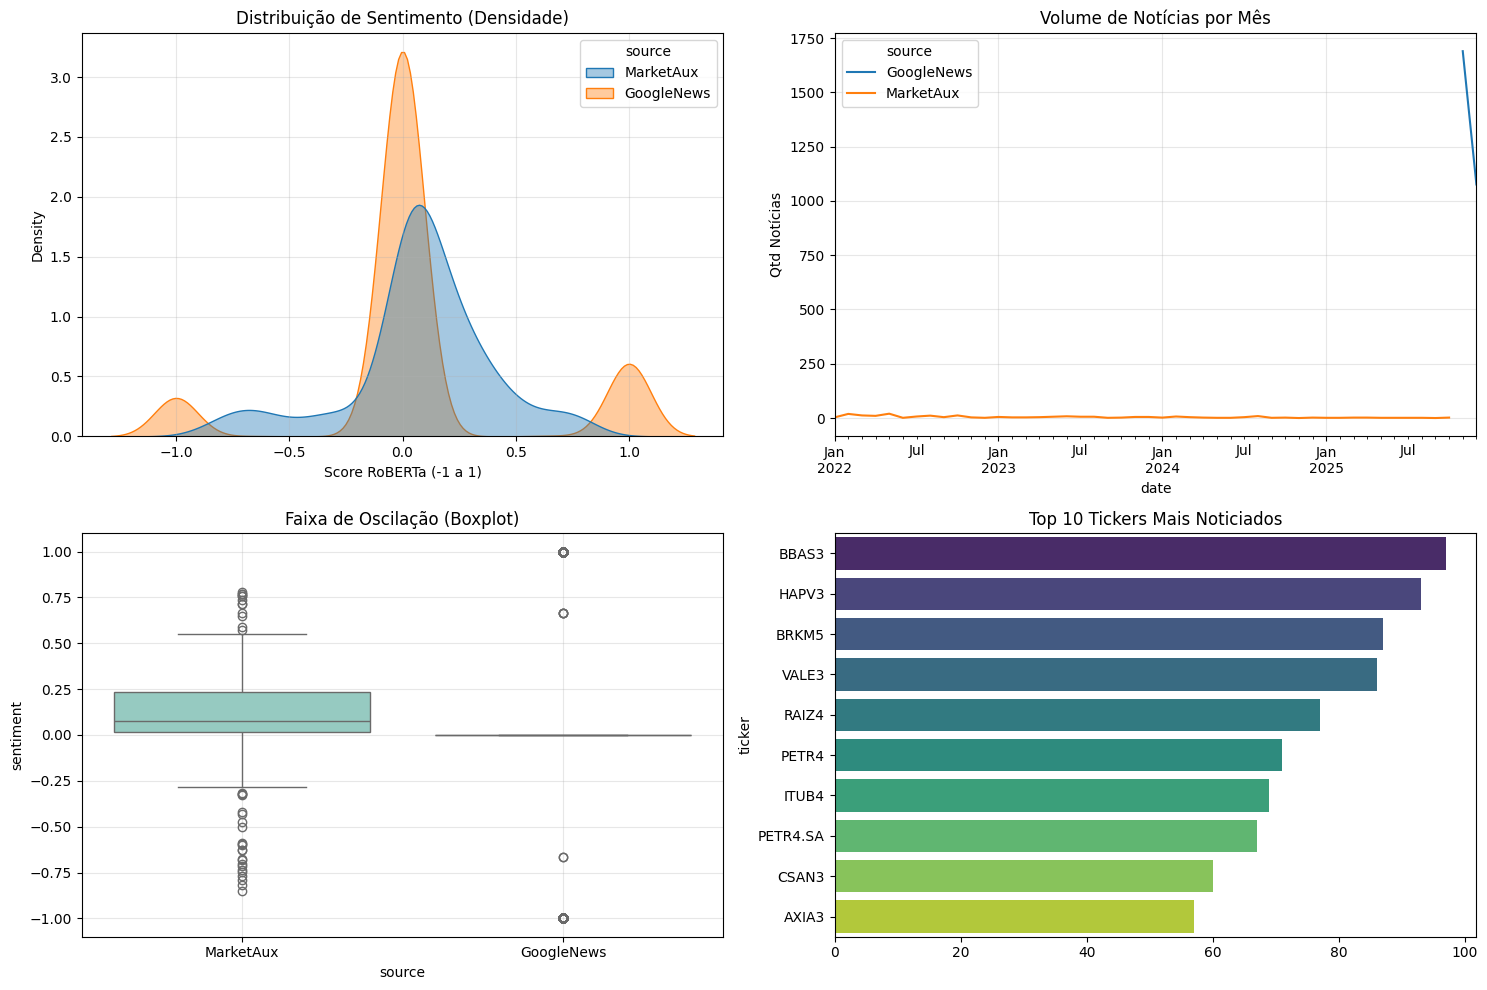

In [2]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- CONFIGURAÇÃO ---
PATH_MKT_ROBERTA = "../data/news/processed/marketaux_roberta"
PATH_GOOGLE = "../data/news/news_with_sentiment.parquet"
OUTPUT_REPORT = "../data/news/reports"

Path(OUTPUT_REPORT).mkdir(parents=True, exist_ok=True)

def carregar_marketaux():
    print("📦 Carregando MarketAux (RoBERTa)...")
    arquivos = glob.glob(os.path.join(PATH_MKT_ROBERTA, "*.parquet"))
    dfs = []
    for f in arquivos:
        try:
            df = pd.read_parquet(f)
            if not df.empty and 'sentiment' in df.columns:
                df['source'] = 'MarketAux'
                # Garante data limpa
                df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.tz_localize(None)
                dfs.append(df[['date', 'ticker', 'sentiment', 'source']])
        except: pass
    
    if not dfs: return pd.DataFrame()
    return pd.concat(dfs, ignore_index=True)

def carregar_google():
    print("📦 Carregando Google News...")
    try:
        if os.path.exists(PATH_GOOGLE):
            df = pd.read_parquet(PATH_GOOGLE)
        elif os.path.exists(PATH_GOOGLE.replace('.parquet', '.csv')):
            df = pd.read_csv(PATH_GOOGLE.replace('.parquet', '.csv'))
        else:
            return pd.DataFrame()
            
        # Ajusta colunas para bater com o padrão
        col_sent = 'sentiment_weighted' if 'sentiment_weighted' in df.columns else 'numeric_sentiment'
        
        df = df.rename(columns={
            'ticker_query': 'ticker',
            'published_date': 'date',
            col_sent: 'sentiment'
        })
        
        df['source'] = 'GoogleNews'
        df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.tz_localize(None)
        
        return df[['date', 'ticker', 'sentiment', 'source']]
        
    except Exception as e:
        print(f"Erro Google: {e}")
        return pd.DataFrame()

def gerar_analise():
    print("--- 🔬 INICIANDO AUDITORIA DE DADOS (ROBERTA UNIFIED) ---")
    
    # 1. Carrega Tudo
    df_mkt = carregar_marketaux()
    df_goog = carregar_google()
    
    if df_mkt.empty and df_goog.empty:
        print("❌ Nenhum dado encontrado. Verifique se rodou os scripts anteriores.")
        return

    df_full = pd.concat([df_mkt, df_goog], ignore_index=True)
    
    # 2. Estatísticas Gerais
    print(f"\n{'='*40}")
    print(f"📊 RELATÓRIO GERAL")
    print(f"{'='*40}")
    print(f"🔹 Total de Notícias: {len(df_full)}")
    print(f"   - MarketAux: {len(df_mkt)}")
    print(f"   - Google News: {len(df_goog)}")
    print(f"🔹 Período: {df_full['date'].min()} até {df_full['date'].max()}")
    print(f"🔹 Tickers Únicos: {df_full['ticker'].nunique()}")
    
    # 3. Comparativo de Sentimento (O Mais Importante)
    print("\n⚖️ COMPARATIVO DE SENTIMENTO (ROBERTA):")
    stats = df_full.groupby('source')['sentiment'].describe().transpose()
    print(stats)
    
    # 4. Detecção de "Zeros Absolutos" (Falha de modelo ou Neutralidade real?)
    zeros = df_full[df_full['sentiment'] == 0.0]
    print(f"\n⚠️ Sentimentos Neutros Exatos (0.0): {len(zeros)} ({len(zeros)/len(df_full)*100:.1f}%)")
    
    # --- VISUALIZAÇÃO ---
    print("\n🎨 Gerando Gráficos...")
    plt.figure(figsize=(15, 10))
    
    # Gráfico A: Distribuição de Sentimento (Histograma Comparativo)
    plt.subplot(2, 2, 1)
    sns.kdeplot(data=df_full, x='sentiment', hue='source', fill=True, common_norm=False, alpha=0.4)
    plt.title("Distribuição de Sentimento (Densidade)")
    plt.xlabel("Score RoBERTa (-1 a 1)")
    plt.grid(alpha=0.3)
    
    # Gráfico B: Volume Histórico (Linha do Tempo)
    plt.subplot(2, 2, 2)
    df_full.set_index('date').groupby('source').resample('M').size().unstack(0).plot(ax=plt.gca())
    plt.title("Volume de Notícias por Mês")
    plt.ylabel("Qtd Notícias")
    plt.grid(alpha=0.3)
    
    # Gráfico C: Boxplot (Variância)
    plt.subplot(2, 2, 3)
    sns.boxplot(data=df_full, x='source', y='sentiment', palette="Set3")
    plt.title("Faixa de Oscilação (Boxplot)")
    plt.grid(alpha=0.3)
    
    # Gráfico D: Top Tickers
    plt.subplot(2, 2, 4)
    top_tickers = df_full['ticker'].value_counts().head(10)
    sns.barplot(x=top_tickers.values, y=top_tickers.index, palette="viridis")
    plt.title("Top 10 Tickers Mais Noticiados")
    
    plt.tight_layout()
    file_img = f"{OUTPUT_REPORT}/auditoria_roberta_full.png"
    plt.savefig(file_img)
    print(f"💾 Dashboard salvo em: {file_img}")
    plt.show()

if __name__ == "__main__":
    gerar_analise()